In [ ]:
!python3 -V

Python 3.10.12


In [ ]:
import json

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
plots = []

In [ ]:
with open('32loss.json', 'r') as file:
    dic = json.load(file)


In [ ]:
indices = []
values = []
for index, nested_dict in dic.items():
    if int(index) <= 15000:
      indices.append(int(index))
      values.append(nested_dict['recons_score'])  # Replace 'value1' with the key of the value you want to plot

plots.append((indices, values))




In [ ]:
len(plots)

8

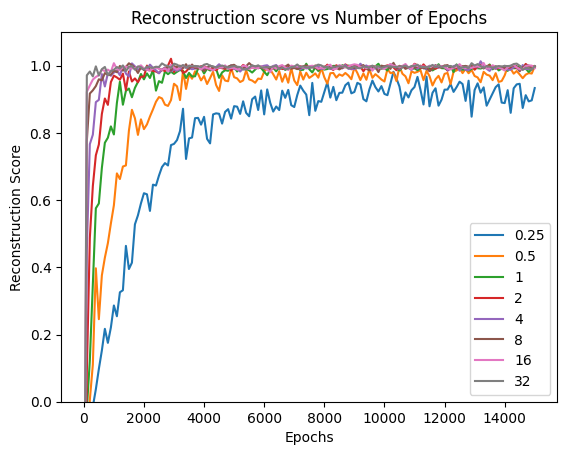

In [ ]:
labels = ["0.25", "0.5", "1", "2", "4", "8", "16", "32"]
for i in range(len(plots)):
  plt.plot([j*50 for j in  plots[i][0]], plots[i][1], label=labels[i])

plt.xlabel('Epochs')
plt.ylabel('Reconstruction Score')
plt.title("Reconstruction score vs Number of Epochs")
plt.ylim(0, 1.1)
plt.xticks(range(0, 15000, 2000))
plt.legend()
plt.show()

In [ ]:
loss_plots=[]

In [ ]:

with open('32loss.json', 'r') as file:
    dic = json.load(file)

In [ ]:
loss_indices = []
loss_values = []
for index, nested_dict in dic.items():
    if int(index) <= 15000:
      loss_indices.append(index)
      loss_values.append(nested_dict['loss'])  # Replace 'value1' with the key of the value you want to plot

loss_plots.append((loss_indices, loss_values))


In [ ]:
len(loss_plots)

8

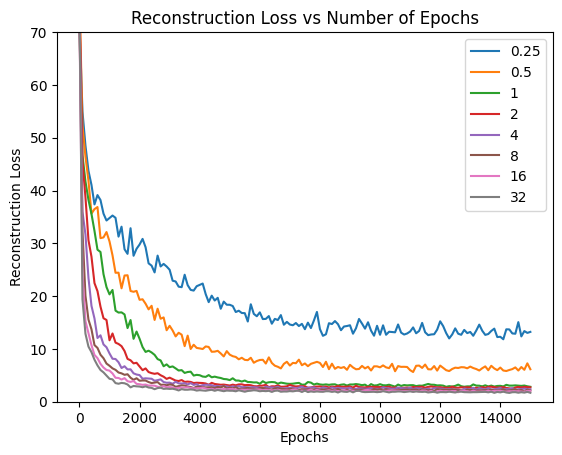

In [ ]:

labels = ["0.25", "0.5", "1", "2", "4", "8", "16", "32"]
for i in range(len(loss_plots)):
  plt.plot(loss_plots[i][0], loss_plots[i][1], label=labels[i])

plt.xlabel('Epochs')
plt.ylabel('Reconstruction Loss')
plt.title("Reconstruction Loss vs Number of Epochs")
plt.ylim(0, 70)
plt.xticks(range(0, 150, 20))
plt.legend()
plt.show()

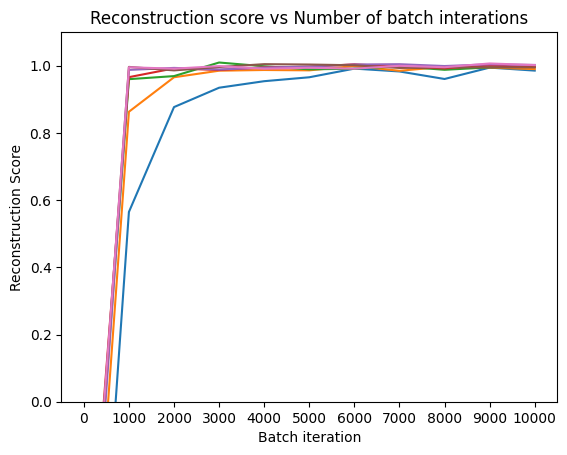

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'data' is your dictionary
indices = []
values = []

for index, nested_dict in dic_05.items():
    if int(index) <= 10000:
      indices.append(index)
      values.append(nested_dict['recons_score'])  # Replace 'value1' with the key of the value you want to plot

plt.plot(indices, values)
plt.plot(indices2, values2)
plt.plot(indices3, values3)
plt.plot(indices4, values4)
plt.plot(indices8, values8)
plt.plot(indices16, values16)
plt.plot(indices32, values32)
plt.xlabel('Batch iteration')
plt.ylabel('Reconstruction Score')
plt.title("Reconstruction score vs Number of batch interations")
plt.ylim(0, 1.1)

plt.show()

In [ ]:
with open('32loss_at_epoch.json', 'r') as file:
   dic_32 = json.load(file)

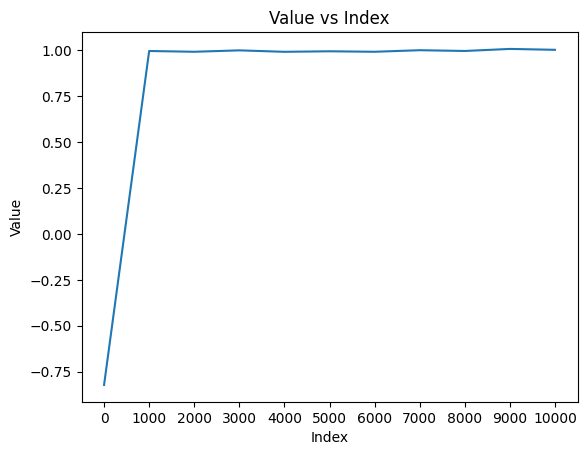

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'data' is your dictionary
indices32 = []
values32 = []

for index, nested_dict in dic_32.items():
    if int(index) <= 10000:
      indices32.append(index)
      values32.append(nested_dict['recons_score'])  # Replace 'value1' with the key of the value you want to plot

plt.plot(indices32, values32)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Value vs Index')
plt.show()

In [ ]:
with open('0.5loss_at_epoch.json', 'r') as file:
   dic_0 = json.load(file)

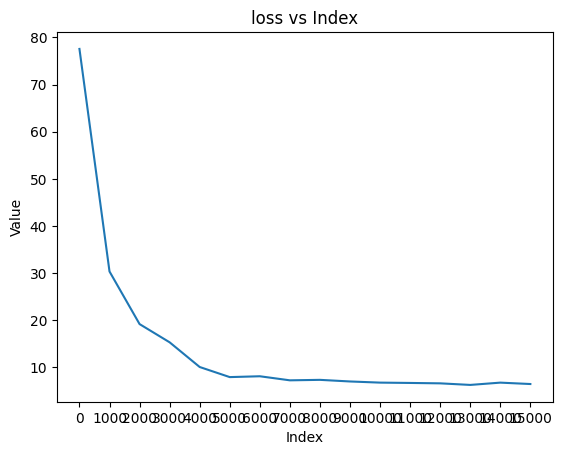

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'data' is your dictionary
indices_loss = []
values_loss = []

for index, nested_dict in dic_0.items():
    if int(index) <= 15000:
      indices_loss.append(index)
      values_loss.append(nested_dict['loss'])  # Replace 'value1' with the key of the value you want to plot

plt.plot(indices_loss, values_loss)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('loss vs Index')
plt.show()

In [ ]:
cfg = {
    "seed": 49,
    "batch_size": 50,
    "buffer_mult": 50*59,
    "lr": 1e-4,
    "num_tokens": int(2e9),
    "l1_coeff": 3e-4,
    "beta1": 0.9,
    "beta2": 0.99,
    "dict_mult": 8,
    "seq_len": 60,
    "enc_dtype":"fp32",
    "remove_rare_dir": False,
    "model_name": "gelu-2l",
    "site": "mlp_out",
    "layer": 5,
    "device": "cuda:0",
    "act_name": f"blocks.4.hook_mlp_out",
    "model_batch_size": 50,
    "remove_rare_dir": False,
}
cfg["model_batch_size"] = 64
cfg["buffer_size"] = cfg["batch_size"] * cfg["buffer_mult"]
cfg["buffer_batches"] = cfg["buffer_size"] // cfg["seq_len"]

In [ ]:
site_to_size = {
    "mlp_out": 512,
    "post": 2048,
    "resid_pre": 512,
    "resid_mid": 512,
    "resid_post": 512,
}
def post_init_cfg(cfg):
    #cfg["model_batch_size"] = cfg["batch_size"] // cfg["seq_len"] * 16
    cfg["buffer_size"] = cfg["batch_size"] * cfg["buffer_mult"]
    cfg["buffer_batches"] = cfg["buffer_size"] // cfg["seq_len"]
    cfg["act_size"] = 512
    cfg["dict_size"] = cfg["act_size"] * cfg["dict_mult"]
    cfg["name"] = f"{cfg['model_name']}_{cfg['layer']}_{cfg['dict_size']}_{cfg['site']}"

post_init_cfg(cfg)

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        d_hidden = cfg["dict_size"]
        l1_coeff = cfg["l1_coeff"]
        dtype = torch.float32
        torch.manual_seed(cfg["seed"])
        self.W_enc = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(cfg["act_size"], d_hidden, dtype=dtype)))
        self.W_dec = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_hidden, cfg["act_size"], dtype=dtype)))
        self.b_enc = nn.Parameter(torch.zeros(d_hidden, dtype=dtype))
        self.b_dec = nn.Parameter(torch.zeros(cfg["act_size"], dtype=dtype))

        self.W_dec.data[:] = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)

        self.d_hidden = d_hidden
        self.l1_coeff = l1_coeff

        self.to(cfg["device"])

    def forward(self, x):
        x_cent = x - self.b_dec
        acts = F.relu(x_cent @ self.W_enc + self.b_enc)
        x_reconstruct = acts @ self.W_dec + self.b_dec
        l2_loss = (x_reconstruct.float() - x.float()).pow(2).sum(-1).mean(0)
        l1_loss = self.l1_coeff * (acts.float().abs().sum())
        loss = l2_loss + l1_loss
        return loss, x_reconstruct, acts, l2_loss, l1_loss

    @torch.no_grad()
    def make_decoder_weights_and_grad_unit_norm(self):
        W_dec_normed = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
        W_dec_grad_proj = (self.W_dec.grad * W_dec_normed).sum(-1, keepdim=True) * W_dec_normed
        self.W_dec.grad -= W_dec_grad_proj
        # Bugfix(?) for ensuring W_dec retains unit norm, this was not there when I trained my original autoencoders.
        self.W_dec.data = W_dec_normed

    def get_version(self):
        version_list = [int(file.name.split(".")[0]) for file in list(SAVE_DIR.iterdir()) if "pt" in str(file)]
        if len(version_list):
            return 1+max(version_list)
        else:
            return 0

    def save(self):
        version = self.get_version()
        torch.save(self.state_dict(), SAVE_DIR/(str(version)+".pt"))
        with open(SAVE_DIR/(str(version)+"_cfg.json"), "w") as f:
            json.dump(cfg, f)
        print("Saved as version", version)

    @classmethod
    def load(cls, version):
        cfg = (json.load(open(SAVE_DIR/(str(version)+"_cfg.json"), "r")))
        pprint.pprint(cfg)
        self = cls(cfg=cfg)
        self.load_state_dict(torch.load(SAVE_DIR/(str(version)+".pt")))
        return self

    @classmethod
    def load_from_hf(cls, version):
        """
        Loads the saved autoencoder from HuggingFace.

        Version is expected to be an int, or "run1" or "run2"

        version 25 is the final checkpoint of the first autoencoder run,
        version 47 is the final checkpoint of the second autoencoder run.
        """
        if version=="run1":
            version = 25
        elif version=="run2":
            version = 47

        cfg = utils.download_file_from_hf("NeelNanda/sparse_autoencoder", f"{version}_cfg.json")

        self = cls(cfg=cfg)
        self.load_state_dict(utils.download_file_from_hf("NeelNanda/sparse_autoencoder", f"{version}.pt", force_is_torch=True))
        return self

In [ ]:
class Buffer():
    """
    This defines a data buffer, to store a bunch of MLP acts that can be used to train the autoencoder. It'll automatically run the model to generate more when it gets halfway empty.
    """
    def __init__(self, cfg):
        self.buffer = torch.zeros((cfg["buffer_size"], cfg["act_size"]), dtype=torch.float16, requires_grad=False).to(cfg["device"])
        self.cfg = cfg
        self.token_pointer = 0
        self.first = True
        self.refresh()

    @torch.no_grad()
    def refresh(self, data=None):
        self.pointer = 0
        with torch.autocast("cuda", torch.float16):
            if self.first:
                num_batches = self.cfg["buffer_batches"]
            else:
                num_batches = self.cfg["buffer_batches"]//2
            self.first = False
            for _ in range(0, num_batches, self.cfg["model_batch_size"]):
                if data:
                  seqs = data
                else:
                  seqs = board_seqs_int[self.token_pointer:self.token_pointer+self.cfg["model_batch_size"]]

                _, cache = model.run_with_cache(seqs[:,:-1], stop_at_layer=cfg["layer"]+1) #, names_filter=cfg["act_name"])
                cache = {cfg["act_name"]: cache[cfg["act_name"]]}
                acts = cache[(cfg["act_name"])].reshape(-1, self.cfg["act_size"])


                # print(tokens.shape, acts.shape, self.pointer, self.token_pointer)
                #print(acts.shape, self.buffer.shape)
                self.buffer[self.pointer: self.pointer+acts.shape[0]] = acts
                self.pointer += acts.shape[0]
                self.token_pointer += self.cfg["model_batch_size"]
                if self.token_pointer > (len(board_seqs_int)*0.8) - self.cfg["model_batch_size"]:
                  print("RESET")
                  self.token_pointer = 0

        self.pointer = 0
        if not data:
          self.buffer = self.buffer[torch.randperm(self.buffer.shape[0])]
        self.buffer = self.buffer.to(cfg["device"])

    @torch.no_grad()
    def next(self):
        out = self.buffer[self.pointer:self.pointer+self.cfg["batch_size"]]
        self.pointer += self.cfg["batch_size"]
        if self.pointer > self.buffer.shape[0]//2 - self.cfg["batch_size"]:
            # print("Refreshing the buffer!")
            self.refresh()
        return out

@torch.no_grad()
def get_recons_loss(num_batches=5, local_encoder=None):
    if local_encoder is None:
        local_encoder = encoder
    loss_list = []
    for i in range(num_batches):
        size = int(len(board_seqs_int)*0.8)
        seqs = board_seqs_int[size:][torch.randperm(len(board_seqs_int) - size)[:cfg["model_batch_size"]]]
        loss = model(seqs[:, :-1].cuda(), return_type="loss")
        recons_loss = model.run_with_hooks(seqs[:, :-1], return_type="loss", fwd_hooks=[(cfg["act_name"], partial(replacement_hook, encoder=local_encoder))])
        # mean_abl_loss = model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(cfg["act_name"], mean_ablate_hook)])
        zero_abl_loss = model.run_with_hooks(seqs[:, :-1], return_type="loss", fwd_hooks=[(cfg["act_name"], zero_ablate_hook)])
        loss_list.append((loss, recons_loss, zero_abl_loss))
    losses = torch.tensor(loss_list)
    loss, recons_loss, zero_abl_loss = losses.mean(0).tolist()

    print(loss, recons_loss, zero_abl_loss)
    score = ((zero_abl_loss - recons_loss)/(zero_abl_loss - loss))
    print(f"{score:.2%}")
    # print(f"{((zero_abl_loss - mean_abl_loss)/(zero_abl_loss - loss)).item():.2%}")
    return score, loss, recons_loss, zero_abl_loss
import json

In [ ]:
encoder = AutoEncoder(cfg)
encoder.load_state_dict(torch.load("81.pt"))

<All keys matched successfully>